In [255]:
import numpy as np
import math
import matplotlib.pyplot as plt
from scipy.special import j0, j1, gamma
class Hyperuniform_helper:
    def __init__(self, w_radius, center_pos, positions, rho):
        self.radius = w_radius #  radius of spherical window
        self.positions = positions #  positions of particles in box
        self.center_pos = center_pos #  origin selected
        self.bulk_density = rho #  density in the box

    def select_from_spherial_window(self):
        # this function selects all positions within a hyperspherical window
        squared_distances = np.sum((self.positions - self.center_pos)**2, axis=1)
        selected_positions = self.positions[squared_distances <= self.radius**2]
        return selected_positions
    
    def calculate_radial_distribution(self, num_bins, d=2):
        # This function calculates a discrete g(r) at 0<=r<=R
        selected_pos = self.select_from_spherial_window()
        distances = np.sort(np.linalg.norm(selected_pos-self.center_pos, axis=1))
        r_values = np.linspace(0, self.radius, num_bins+1)
        gr = np.zeros_like(r_values)

        self.bulk_density = len(selected_pos)/(np.pi**(d/2)*self.radius**d/gamma(1+d/2))
        #r_centers = (r_values[:-1] + r_values[1:]) / 2

        # Compute counts in each bin using np.histogram
        counts, _ = np.histogram(distances, bins=r_values)

        # Compute shell volumes for each bin
        shell_volumes = np.pi**(d / 2) * (r_values[1:]**d - r_values[:-1]**d) / gamma(1 + d / 2)

        # Normalize counts to compute g(r)
        gr[1:] = counts / (shell_volumes * self.bulk_density)
        return r_values, gr 
    
    def hankel_transform_2d(self, gr, r, k_values):
        hk = np.zeros(len(k_values))
        delta_r = np.diff(r)[0]
        for i in range(len(k_values)):
            integrand = r*(gr-1)*j0(k_values[i]*r)
            hk[i] = 2*np.pi*np.trapezoid(integrand, r, dx=delta_r)
        return 1+self.bulk_density*hk
    
    def variance_calculation_in_real_space(self, r, gr):
        delta_r = np.diff(r)[0]
        window_intersection = 2/np.pi*(np.acos(r/(2*self.radius))-r/(2*self.radius)*(1-r**2/(4*self.radius**2))**0.5)
        integrand = r*(gr-1)*window_intersection
        return self.bulk_density*np.pi*self.radius**2*(1+self.bulk_density*2*np.pi*np.trapezoid(integrand, r, dx=delta_r))
    
    def variance_calculations_in_reciprocal_space_2d(self, sk, k):
        delta_k = np.diff(k)[0]  # Assuming uniform spacing
        integrand = k*sk*(2**2*np.pi*gamma(2)*j1(k*self.radius)**2/k**2)
        variance_square = self.bulk_density*np.pi*self.radius**2*(1/(2*np.pi)*np.trapezoid(integrand, k, dx=delta_k))
        return variance_square
    

In [259]:
file_name = 'positions.txt'
data = np.loadtxt(file_name)
rho, box_length, volume_fraction = data[0]
helper = Hyperuniform_helper(box_length/2, np.zeros(3), data[1:,], rho)
r, gr = helper.calculate_radial_distribution(30, 2)
print(helper.bulk_density)


0.21040933088761185


Text(0, 0.5, 'radial distribution function g(r)')

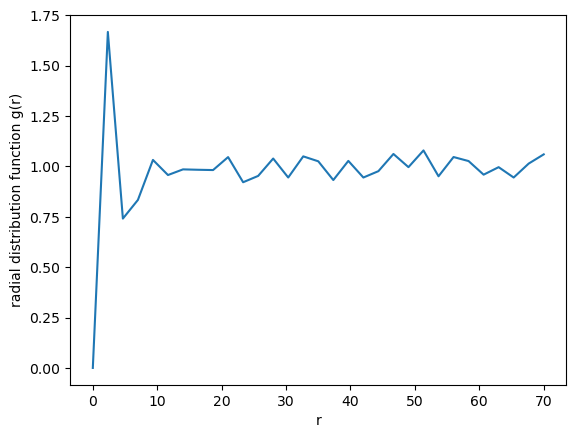

In [260]:
plt.plot(r, gr)
plt.xlabel("r")
plt.ylabel("radial distribution function g(r)")

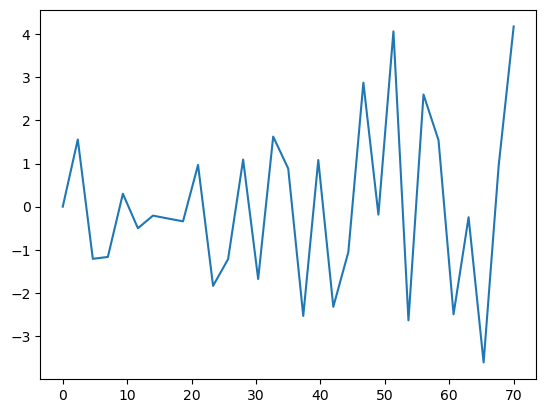

In [261]:
plt.plot(r, r*(gr-1))

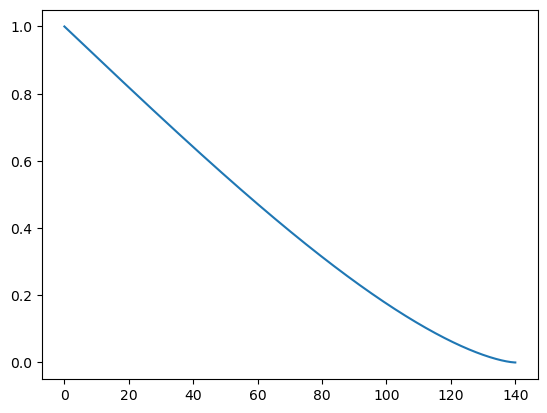

In [262]:
def window_intersection(r, radius):
    return 2/np.pi*(np.acos(r/(2*radius))-r/(2*radius)*(1-r**2/(4*radius**2))**0.5)

x = np.linspace(0, box_length, 1000)
y = window_intersection(x, box_length/2)
plt.plot(x,y)

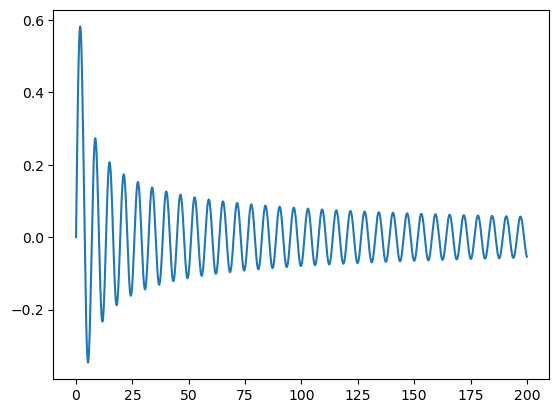

In [263]:
x = np.linspace(0, 200, 10001)
y = j1(x)

plt.plot(x, y)

-0.015437439930564947


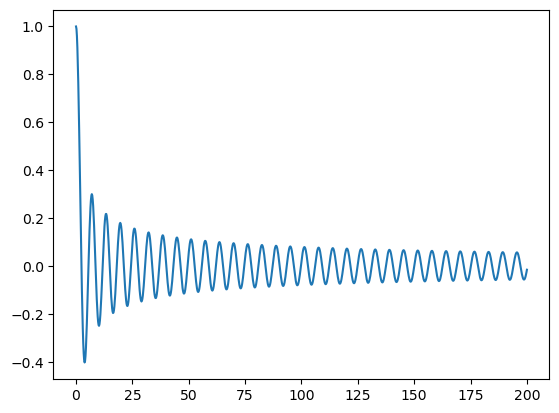

In [264]:
x = np.linspace(0, 200, 1000)
y = j0(x)

plt.plot(x, y)
print(y[-1])

Text(0, 0.5, 'Structure factor sk')

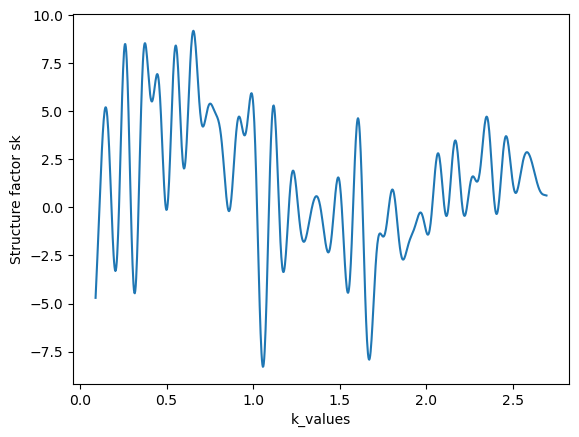

In [271]:
k_values = np.linspace(2*np.pi/(box_length/2), 2*np.pi/r[1], 1001)
sk = helper.hankel_transform_2d(gr, r, k_values)
plt.plot(k_values, sk)
plt.xlabel("k_values")
plt.ylabel("Structure factor sk")

In [272]:
variance_square=helper.variance_calculation_in_real_space(r, gr)
print(variance_square)

-17413.94091335749


In [273]:
variance_square = helper.variance_calculations_in_reciprocal_space_2d(sk, k_values)
print(variance_square)

609.2391280410442


In [270]:
def particles_in_windows_real_variances(positions, origin1, radius):
    return np.sum(np.linalg.norm(positions-origin1, axis=1)<radius)
x_range = np.linspace(-1/8, 1/8, 1001)*box_length
y_range = np.linspace(-1/8, 1/8, 1001)*box_length
num_particles = np.zeros(1001)
for i in range(len(x_range)):
    particles = (particles_in_windows_real_variances(data[1:], origin1=np.array([x_range[i], y_range[i], 0]), radius=1*box_length/8))
    num_particles[i] = particles
print(num_particles)
print(np.mean(num_particles))
print(num_particles-np.mean(num_particles))
print(np.average((num_particles-np.mean(num_particles))**2))

[202. 203. 203. ... 215. 214. 215.]
199.78821178821178
[ 2.21178821  3.21178821  3.21178821 ... 15.21178821 14.21178821
 15.21178821]
29.39370719190899
